In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/comp-6461-yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/comp-6461-yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/comp-6461-yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/comp-6461-yelp-dataset/yelp_academic_dataset_tip.json


In [2]:
import pandas as pd
import json
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

pd.set_option('display.max_columns', None)

In [3]:
# Load JSON data into list
data_business = []

with open('/kaggle/input/comp-6461-yelp-dataset/yelp_academic_dataset_business.json', 'r') as f:
    for line in f:
        data_business.append(json.loads(line))

In [4]:
# Load JSON data into list
data_checkin = []

with open('/kaggle/input/comp-6461-yelp-dataset/yelp_academic_dataset_checkin.json', 'r') as f:
    for line in f:
        data_checkin.append(json.loads(line))

In [5]:
# Load JSON data into list
data_review = []

with open('/kaggle/input/comp-6461-yelp-dataset/yelp_academic_dataset_review.json', 'r') as f:
    for line in f:
        data_review.append(json.loads(line))

In [6]:
# Load JSON data into list
data_tip = []

with open('/kaggle/input/comp-6461-yelp-dataset/yelp_academic_dataset_tip.json', 'r') as f:
    for line in f:
        data_tip.append(json.loads(line))

In [7]:
# Convert into Pandas DataFrame 

df_business = pd.DataFrame(data_business).sample(n=30000, random_state=42).reset_index(drop=True)
df_tip = pd.DataFrame(data_tip).sample(n=30000, random_state=42).reset_index(drop=True)
df_review = pd.DataFrame(data_review).sample(n=30000, random_state=42).reset_index(drop=True)

In [8]:
df_checkin  = pd.DataFrame(data_checkin).sample(n=30000, random_state=42).reset_index(drop=True)

In [9]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   30000 non-null  object 
 1   name          30000 non-null  object 
 2   address       30000 non-null  object 
 3   city          30000 non-null  object 
 4   state         30000 non-null  object 
 5   postal_code   30000 non-null  object 
 6   latitude      30000 non-null  float64
 7   longitude     30000 non-null  float64
 8   stars         30000 non-null  float64
 9   review_count  30000 non-null  int64  
 10  is_open       30000 non-null  int64  
 11  attributes    27173 non-null  object 
 12  categories    29978 non-null  object 
 13  hours         25312 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 3.2+ MB


In [10]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    30000 non-null  object 
 1   user_id      30000 non-null  object 
 2   business_id  30000 non-null  object 
 3   stars        30000 non-null  float64
 4   useful       30000 non-null  int64  
 5   funny        30000 non-null  int64  
 6   cool         30000 non-null  int64  
 7   text         30000 non-null  object 
 8   date         30000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.1+ MB


In [11]:
df_tip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           30000 non-null  object
 1   business_id       30000 non-null  object
 2   text              30000 non-null  object
 3   date              30000 non-null  object
 4   compliment_count  30000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [12]:
df_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  30000 non-null  object
 1   date         30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB


In [13]:
## Download necessary nltk data files

# Set the NLTK data path to a specific location
# nltk.data.path.append('/root/nltk_data')

# Download the necessary resources
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Data Cleaning and Preprocessing

In [14]:
# Initiliaze stopwords and lemmatizer
import spacy

stop_words = set(stopwords.words('english'))

nlp = spacy.load("en_core_web_sm")

In [15]:
df_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,TacYUYhU3HpLHF9Rs6fW2w,Steps to Learning Montessori Preschool,6901 Phelps Rd,Goleta,CA,93117,34.423311,-119.870637,4.5,8,1,"{'BusinessAcceptsCreditCards': 'True', 'WiFi':...","Education, Elementary Schools, Child Care & Da...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:0', '..."
1,RnExaICvIeXxFpbIKEqJsQ,Breeze Blow Dry Bar,9916 Clayton Rd,St. Louis,MO,63124,38.636716,-90.393139,4.0,81,0,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Hair Salons, Beauty & Spas, Hair Stylists, Ski...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ..."


In [16]:
df_review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2.0,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53
1,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5.0,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14


In [17]:
## Create a data cleaning function 

def clean_data(text):
    text = re.sub(r'http\S+|www\S+|https\S+','',text) # Remove Links
    text = re.sub(r'[^\x00-\x7F]+','',text)  # Remove Emojies
    text = re.sub(r'[^a-zA-Z\s]','',text)  # Remove Special Characters,numbers
    text = text.lower()  # Convert into lowecase for uniformatiy
    return text

In [18]:
# Tokenization, stopword removal and lemmatization

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return "".join(tokens)

**Reviews Data**

In [19]:
# Clean the reviews data
df_review['cleaned_text'] = df_review.text.apply(clean_data)

In [20]:
# Now, Preprocess the reviews data
df_review['preprocessed_text'] = df_review.cleaned_text.apply(preprocess_text)

In [21]:
## Let's Validate the Output

df_review[['text','preprocessed_text']].head(3)

,text,preprocessed_text
0,Went for lunch and found that my burger was me...,golunchfindburgermeh obviousfocusburgerdiffere...
1,I needed a new tires for my wife's car. They h...,neednewtirewifecarspecialorderdaydropmorningwo...
2,Jim Woltman who works at Goleta Honda is 5 sta...,jimwoltmanworkgoletahonda starknowledgeablehel...


**Tips Data**

In [22]:
# Clean the tip data
df_tip['cleaned_text'] = df_tip.text.apply(clean_data)

In [23]:
# Now, Preprocess the reviews data
df_tip['preprocessed_text'] = df_tip.cleaned_text.apply(preprocess_text)

In [24]:
## Let's Validate the Output

df_tip[['text','preprocessed_text']].head(3)

,text,preprocessed_text
0,The Herb Roasted Salmon is great....,herbroastedsalmongreat
1,Auditions,audition
2,One of my fave spots in Tampa bay! Double yum!,favespottampabaydoubleyum


**Business Data**

In [25]:
df_business.city.value_counts()

city
Philadelphia        3017
Tampa               1811
Tucson              1776
Indianapolis        1542
Nashville           1419
                    ... 
Whitehouse             1
Newtown Township       1
San Anselmo            1
LANSDALE               1
Sarasota               1
Name: count, Length: 774, dtype: int64

In [26]:
df_business_cleaned = df_business[['business_id', 'name', 'city','stars', 'review_count', 'is_open', 'categories','attributes']]

# we have clean the 'categories' column by splitting categories into individual words
df_business_cleaned['categories'] = df_business_cleaned['categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

/tmp/ipykernel_23/1089553268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business_cleaned['categories'] = df_business_cleaned['categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])


In [27]:
df_business_cleaned.rename(columns={'stars': 'Business_stars'}, inplace=True)

/tmp/ipykernel_23/2656195223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business_cleaned.rename(columns={'stars': 'Business_stars'}, inplace=True)


In [28]:
## Let's Validate the Output
df_business_cleaned.head(3)

,business_id,name,city,Business_stars,review_count,is_open,categories,attributes
0,TacYUYhU3HpLHF9Rs6fW2w,Steps to Learning Montessori Preschool,Goleta,4.5,8,1,"[Education, Elementary Schools, Child Care & D...","{'BusinessAcceptsCreditCards': 'True', 'WiFi':..."
1,RnExaICvIeXxFpbIKEqJsQ,Breeze Blow Dry Bar,St. Louis,4.0,81,0,"[Hair Salons, Beauty & Spas, Hair Stylists, Sk...","{'ByAppointmentOnly': 'False', 'BusinessAccept..."
2,pjtjBeZC3gvmtIiIQt-DFA,Impact Guns,Boise,3.0,39,1,"[Gun/Rifle Ranges, Active Life]","{'BusinessParking': '{'garage': False, 'street..."


**Tip data**

In [29]:
# Convert 'date' column to datetime format 
df_tip['date'] = pd.to_datetime(df_tip['date'])

# Extract year and month
df_tip['year'] = df_tip['date'].dt.year
df_tip['month'] = df_tip['date'].dt.month

In [30]:
## Let's Validate the Output
df_tip.head(2)

,user_id,business_id,text,date,compliment_count,cleaned_text,preprocessed_text,year,month
0,mpS38CQozjwcWPa231SouQ,08q4nEOcz9hc1lRW7UPOng,The Herb Roasted Salmon is great....,2014-03-09 01:27:09,0,the herb roasted salmon is great,herbroastedsalmongreat,2014,3
1,zoQQfvhUJkaC1a_Dve4Rbg,VJJvf5TwX2xXn2mFducV6w,Auditions,2012-07-06 21:55:26,0,auditions,audition,2012,7


**Mergining all the DataFrames into single DataFrame***

In [31]:
# Merge df_business and df_review on 'business_id'
df = pd.merge(df_business_cleaned,
              df_review[['business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'cleaned_text','preprocessed_text']], 
              on='business_id', how='outer', suffixes=('_business', '_review'))

In [32]:
df.rename(columns={'stars':'review_stars','useful':'review_useful','funny':'review_funny','cool':'review_cool','text':'review_text','cleaned_text':'review_cleaned_text','preprocessed_text':'review_preprocessed_text'},inplace=True)

In [33]:
# Merge with df_tip on 'business_id'
df = pd.merge(df, df_tip[['business_id', 'compliment_count', 'text', 'cleaned_text','preprocessed_text','year','month']], 
              on='business_id', how='outer', suffixes=('_review', '_tip'))

In [34]:
df.rename(columns={'compliment_count':'tip_compliment_count','text':'tip_text','cleaned_text':'tip_cleaned_text','preprocessed_text':'tip_preprocessed_text'},inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101566 entries, 0 to 101565
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   business_id               101566 non-null  object 
 1   name                      40030 non-null   object 
 2   city                      40030 non-null   object 
 3   Business_stars            40030 non-null   float64
 4   review_count              40030 non-null   float64
 5   is_open                   40030 non-null   float64
 6   categories                40030 non-null   object 
 7   attributes                37185 non-null   object 
 8   review_stars              62805 non-null   float64
 9   review_useful             62805 non-null   float64
 10  review_funny              62805 non-null   float64
 11  review_cool               62805 non-null   float64
 12  review_text               62805 non-null   object 
 13  review_cleaned_text       62805 non-null   o

In [36]:
## Drop Business_Id column (it's not important for data analysis)
df.drop('business_id',axis=1,inplace=True)

In [37]:
## Remove all the null values

df.dropna(inplace=True)

In [38]:
# Reset the index

df.reset_index(drop=True,inplace=True)

# 2. Exploratory Data Analysis (EDA)

In [39]:
## Import important libraries for EDA
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10340 entries, 0 to 10339
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      10340 non-null  object 
 1   city                      10340 non-null  object 
 2   Business_stars            10340 non-null  float64
 3   review_count              10340 non-null  float64
 4   is_open                   10340 non-null  float64
 5   categories                10340 non-null  object 
 6   attributes                10340 non-null  object 
 7   review_stars              10340 non-null  float64
 8   review_useful             10340 non-null  float64
 9   review_funny              10340 non-null  float64
 10  review_cool               10340 non-null  float64
 11  review_text               10340 non-null  object 
 12  review_cleaned_text       10340 non-null  object 
 13  review_preprocessed_text  10340 non-null  object 
 14  tip_co

**1. Business Stars vs. Review Count**

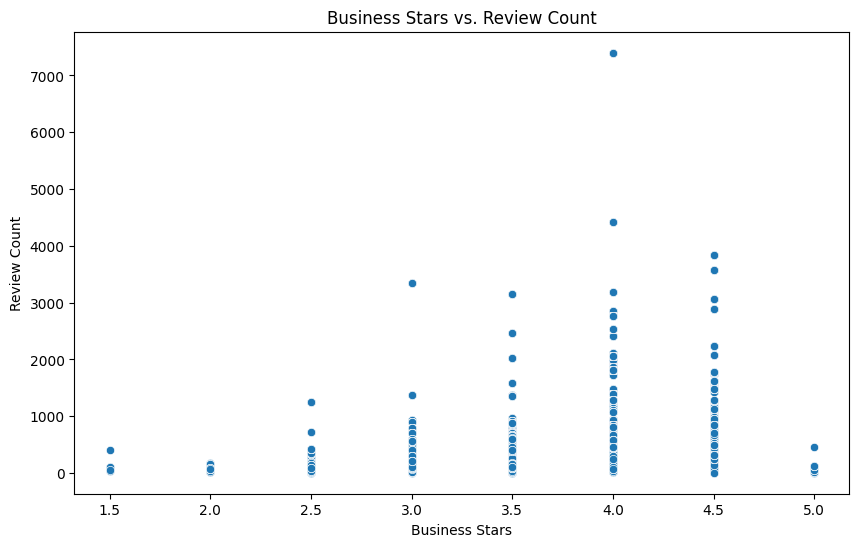

In [41]:
# Scatter plot of Business Stars vs Review Count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Business_stars', y='review_count')
plt.title('Business Stars vs. Review Count')
plt.xlabel('Business Stars')
plt.ylabel('Review Count')
plt.show()

**Insights**:

We have find that businesses with fewer reviews tend to have more extreme ratings (either very high or very low), while those with more reviews tend to have ratings that are more stable or closer to the average.

**2. Distribution of Review Stars**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


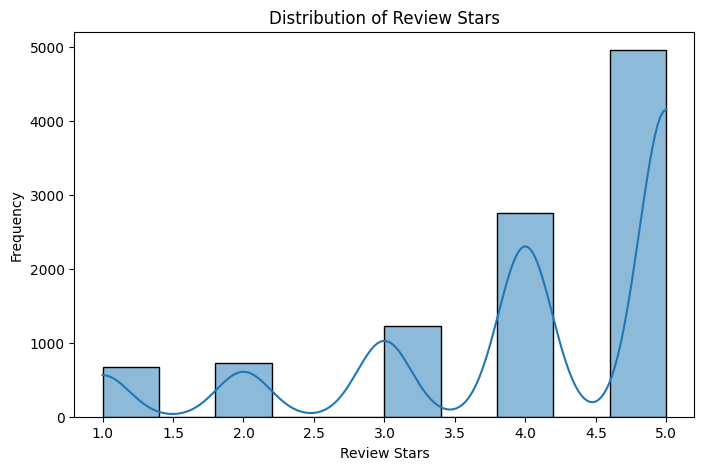

In [42]:
# Distribution of Review Stars
plt.figure(figsize=(8, 5))
sns.histplot(df['review_stars'], bins=10, kde=True)
plt.title('Distribution of Review Stars')
plt.xlabel('Review Stars')
plt.ylabel('Frequency')
plt.show()

**Insights**:

This could help us to understand that the general rating trend. Like most reviews tend to be 4-5 stars

**3. Top 10 Most Frequent Categories**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


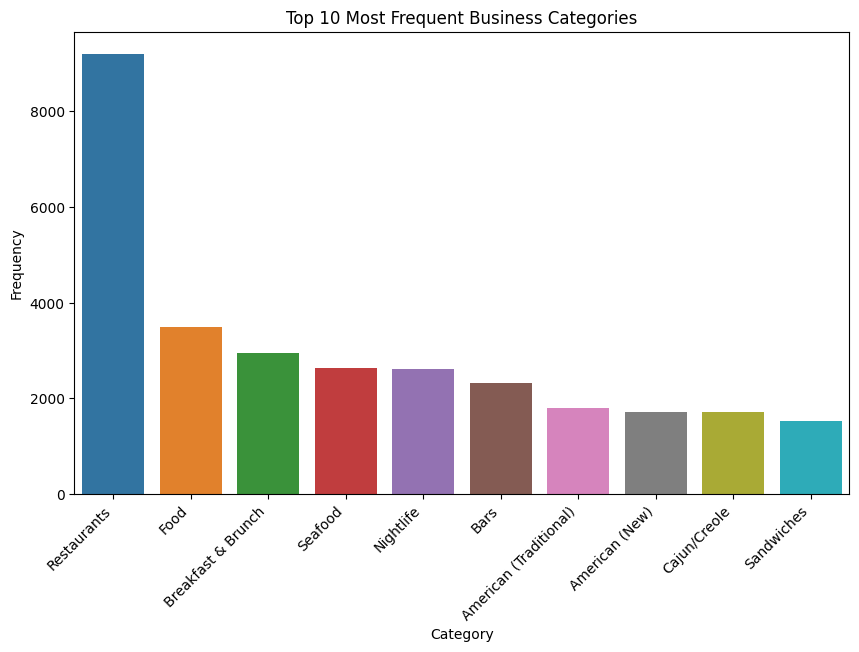

In [43]:
from collections import Counter

# Flatten categories to count frequency of each category
categories = df['categories'].apply(lambda x: eval(x) if isinstance(x, str) else x)
flat_categories = [category for sublist in categories for category in sublist]
category_counts = Counter(flat_categories)

# Get top 10 most frequent categories
top_categories = category_counts.most_common(10)

# Plot
category_names, category_frequencies = zip(*top_categories)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_names), y=list(category_frequencies))
plt.title('Top 10 Most Frequent Business Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

**Insights**:

As we can see that Restaurants and Food businesses are most common here in our dataset.

**4. Business Rating by City**

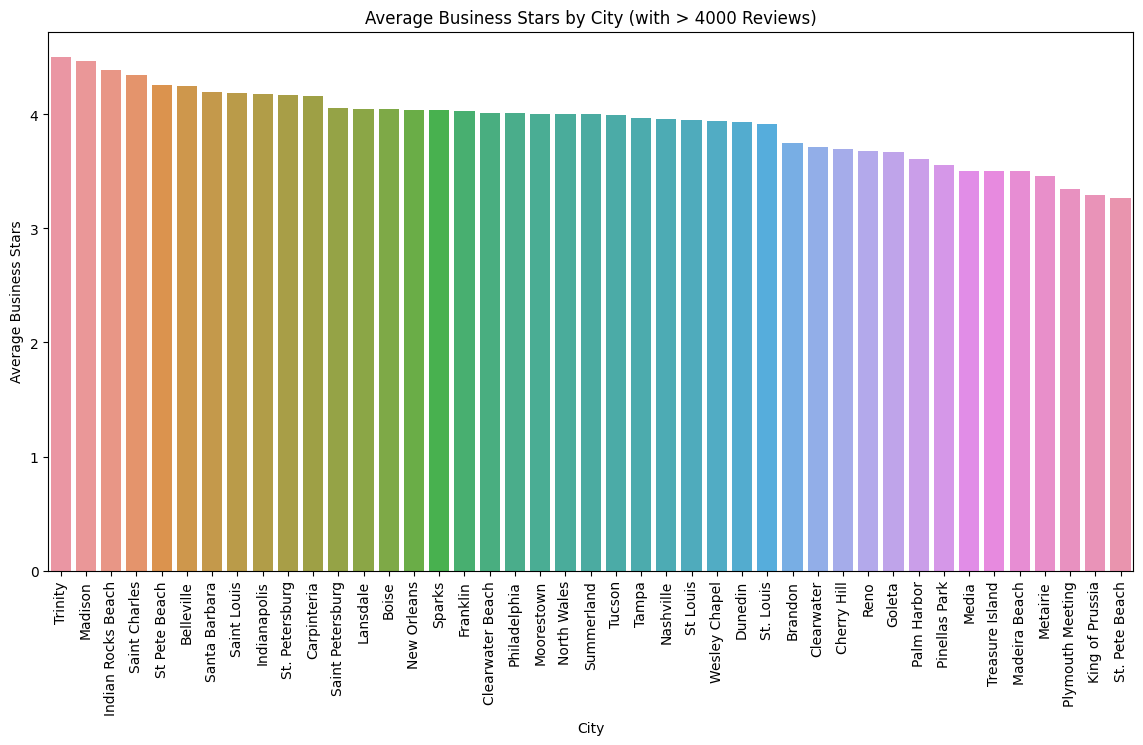

In [44]:
# Filter cities with more than 4000 reviews
city_review_counts = df.groupby('city')['review_count'].sum()
cities_with_more_than_4000_reviews = city_review_counts[city_review_counts > 4000].index

# Filter the original dataframe to include only those cities
filtered_df = df[df['city'].isin(cities_with_more_than_4000_reviews)]

# Calculate average ratings for these cities
city_avg_ratings = filtered_df.groupby('city')['Business_stars'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(x=city_avg_ratings.index, y=city_avg_ratings.values)
plt.title('Average Business Stars by City (with > 4000 Reviews)')
plt.xlabel('City')
plt.ylabel('Average Business Stars')
plt.xticks(rotation=90)
plt.show()

**5. Review Sentiment Analysis**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


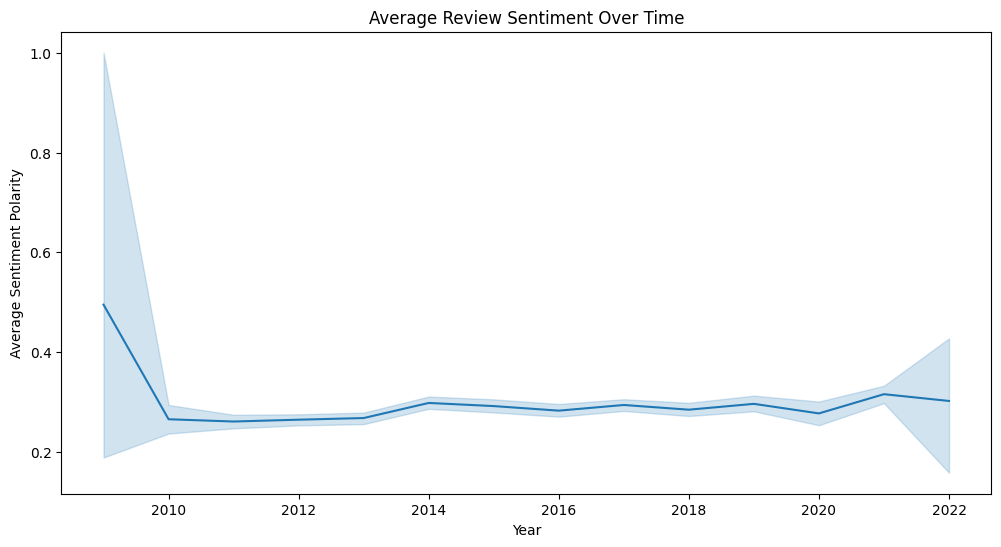

In [45]:
from textblob import TextBlob

# Sentiment polarity of each review
df['review_sentiment'] = df['review_cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='review_sentiment', estimator='mean')
plt.title('Average Review Sentiment Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Polarity')
plt.show()

**Insights**:

Sentiment analysis helps track the overall tone of reviews over time, indicating whether they are becoming more positive or negative. In this case, we observe that shortly after the platform's launch, reviews were more frequent and tended to be more positive and negative. However, over time, as review submissions slowed, the sentiment became more neutral. Following the COVID-19 pandemic, there was a significant boost in online activity, leading to an increase in reviews once again, with sentiment showing more positive and negative trends both as engagement grew.

**6. Businesses that are Open vs. Closed**

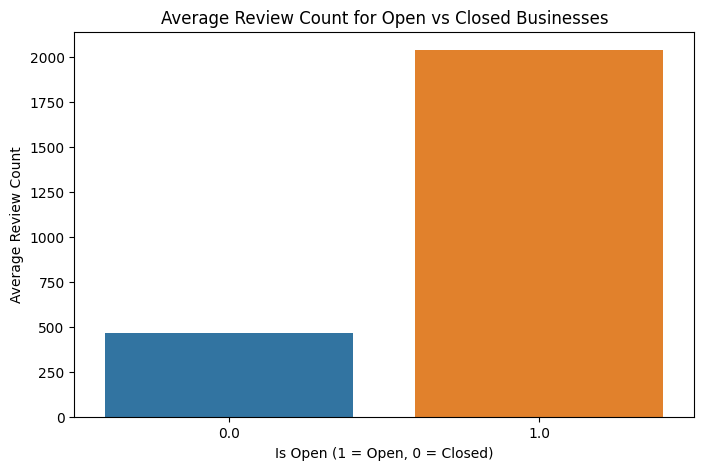

In [46]:
# Average rating and review count for open vs closed businesses
open_vs_closed = df.groupby('is_open').agg({
    'Business_stars': 'mean',
    'review_count': 'mean'
}).reset_index()

# Review Count Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='is_open', y='review_count', data=open_vs_closed)
plt.title('Average Review Count for Open vs Closed Businesses')
plt.xlabel('Is Open (1 = Open, 0 = Closed)')
plt.ylabel('Average Review Count')
plt.show()

**Insights**:

As we can see that there is a huge difference of revies count of open and closed business.

**Top Keywords and Phrases**

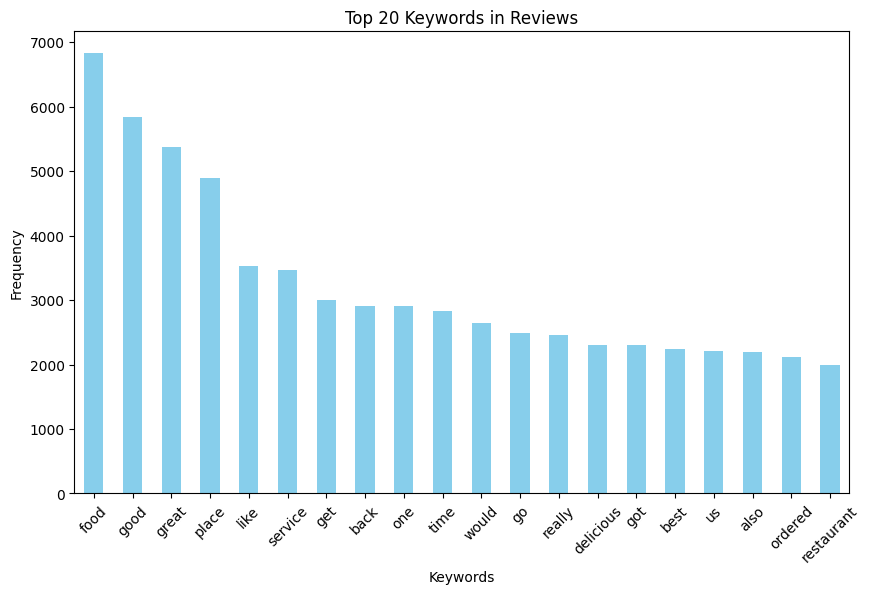

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud


stop_words_list = list(stop_words)

# Vectorize the cleaned review text
vectorizer = CountVectorizer(stop_words=stop_words_list, max_features=50)
X = vectorizer.fit_transform(df['review_cleaned_text'])

# Create a DataFrame with word counts
words_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_count = words_freq.sum(axis=0).sort_values(ascending=False)

# Plot the Top 20 Keywords
plt.figure(figsize=(10, 6))
word_count.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Keywords in Reviews')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

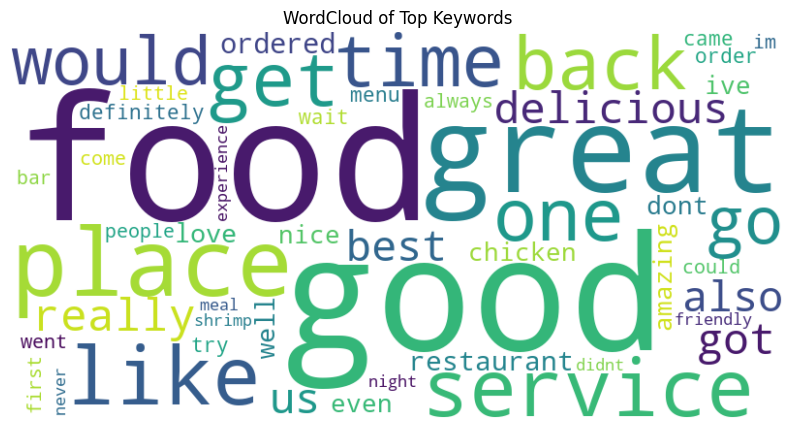

In [48]:
# Create a WordCloud
wordcloud = WordCloud(stopwords=stop_words, width=800, height=400, background_color='white').generate_from_frequencies(word_count)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Top Keywords')
plt.show()

**As we can see above are the uni-grams or the most commonly used words**

new orleans         650
go back             490
come back           442
first time          436
ice cream           397
great food          386
mac cheese          376
really good         369
food good           339
next time           326
service great       320
ive ever            299
great place         282
good food           274
highly recommend    273
feel like           272
food service        240
great service       238
pretty good         235
one best            233
dtype: int64


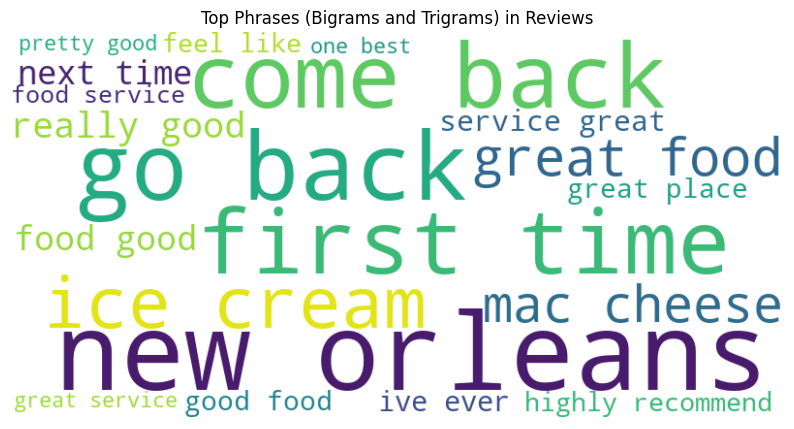

In [49]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Download stopwords from nltk if not already done
# nltk.download('stopwords')
# stop_words = stopwords.words('english')


# Create a CountVectorizer to extract bigrams or trigrams
vectorizer = CountVectorizer(stop_words=stop_words_list, ngram_range=(2, 3), max_features=20)  # bigrams and trigrams
X = vectorizer.fit_transform(df['review_cleaned_text'])

# Get the most common n-grams
n_grams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
n_gram_counts = n_grams.sum(axis=0).sort_values(ascending=False)

# Print the top 20 most common n-grams
print(n_gram_counts.head(20))

# Generate a wordcloud from the most common n-grams
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(n_gram_counts)

# Plot the wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Phrases (Bigrams and Trigrams) in Reviews')
plt.show()

**As we can see above are the Bi-grams and Tri-grams or the most commonly used phrases**

**Frequency of Reviews Over Time**

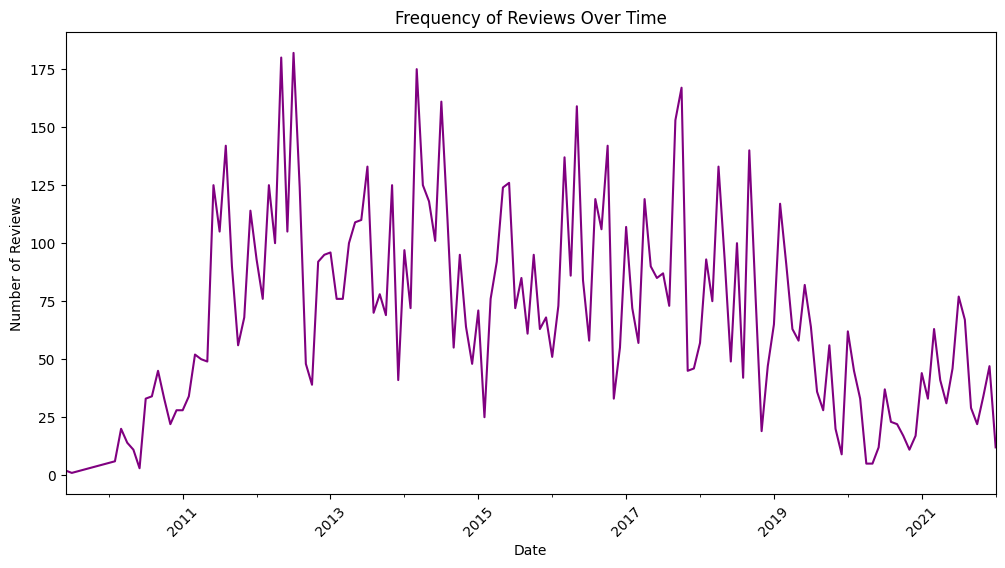

In [50]:
# Convert 'year' and 'month' columns into a single datetime column for better handling
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Group by year and month to count the number of reviews
reviews_over_time = df.groupby(df['date'].dt.to_period('M')).size()

# Plot Frequency of Reviews Over Time (monthly trend)
plt.figure(figsize=(12, 6))
reviews_over_time.plot(kind='line', color='purple')
plt.title('Frequency of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

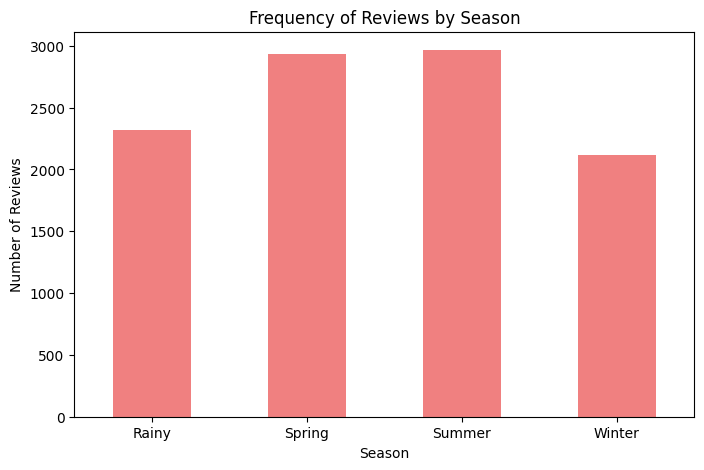

In [51]:
# Define seasons based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Rainy'

# Apply the function to create a 'season' column
df['season'] = df['month'].apply(get_season)

# Count the number of reviews per season
season_counts = df['season'].value_counts().sort_index()

# Plot frequency of reviews by season
plt.figure(figsize=(8, 5))
season_counts.plot(kind='bar', color='lightcoral')
plt.title('Frequency of Reviews by Season')
plt.xlabel('Season')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

**Insights**:

As we can see that maximum number of reviews are from Spring and Summer seasons. We can say that maximum number of customers fall in these seasons only.

In [52]:
## Now let's convert our final dataframe into csv file 

df.to_csv('customer_capstone_project.csv', index=False)